In [1]:
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow as tf
import keras
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, StandardScaler
from keras.utils import Progbar

file_q = h5py.File("datasets/jetnet/q.hdf5", 'r')
file_g = h5py.File("datasets/jetnet/g.hdf5", 'r')
file_w = h5py.File("datasets/jetnet/w.hdf5", 'r')
file_z = h5py.File("datasets/jetnet/z.hdf5", 'r')
file_t = h5py.File("datasets/jetnet/t.hdf5", 'r')
x_q = file_q['particle_features'][:]
x_g = file_g['particle_features'][:]
x_w = file_w['particle_features'][:]
x_z = file_z['particle_features'][:]
x_t = file_t['particle_features'][:]

y_q = np.tile([1,0,0,0,0], (x_q.shape[0], 1))
y_g = np.tile([0,1,0,0,0], (x_g.shape[0], 1))
y_w = np.tile([0,0,1,0,0], (x_w.shape[0], 1))
y_z = np.tile([0,0,0,1,0], (x_z.shape[0], 1))
y_t = np.tile([0,0,0,0,1], (x_t.shape[0], 1))

x_all = np.concatenate([x_q, x_g, x_w, x_z, x_t], axis=0)
y_all = np.concatenate([y_q, y_g, y_w, y_z, y_t], axis=0)

indices = np.arange(x_all.shape[0])
np.random.seed(42)
np.random.shuffle(indices)

x_all = x_all[indices]
y_all = y_all[indices]

n_train = 200000
n_val = 1000
#n_test = x_all.shape[0] - n_train - n_val
n_test = 100000

x_train = x_all[:n_train]
y_train = y_all[:n_train]

x_val = x_all[n_train:n_train + n_val]
y_val = y_all[n_train:n_train + n_val]

x_test = x_all[n_train + n_val:]
y_test = y_all[n_train + n_val:]

x_test = x_test[:n_test]
y_test = y_test[:n_test]

del x_all, y_all

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

2025-08-28 13:54:15.586960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-28 13:54:15.611687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-28 13:54:15.618563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 13:54:15.641967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 13:54:17.584620: W tensorflow/compiler/tf2

x_train shape: (200000, 30, 4)
y_train shape: (200000, 5)
x_val shape: (1000, 30, 4)
y_val shape: (1000, 5)
x_test shape: (100000, 30, 4)
y_test shape: (100000, 5)


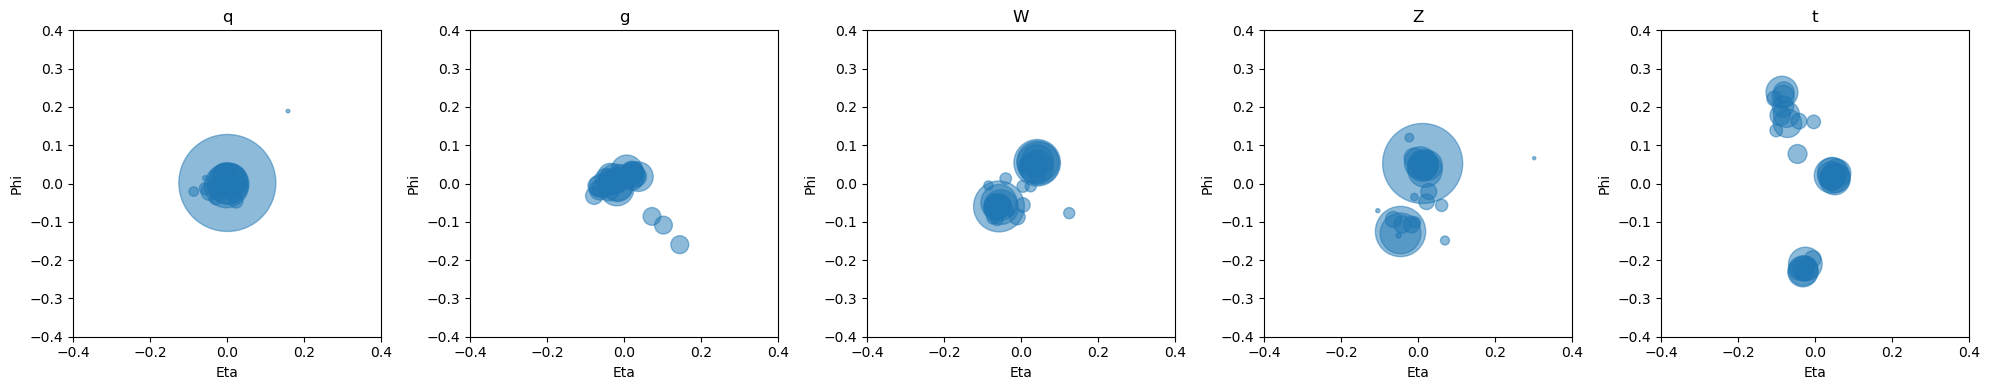

In [2]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
class_names = ['q', 'g', 'W', 'Z', 't']

for i, class_name in enumerate(class_names):
    class_idx = np.where(y_train.argmax(axis=1)==i)[0][0]
    jet = x_train[class_idx]
    eta = jet[:,0]
    phi = jet[:,1]
    pt = jet[:,2]
    mask = jet[:,3]
    
    eta = eta[mask==1]
    phi = phi[mask==1]
    pt = pt[mask==1]

    size = pt*10000

    axs[i].scatter(eta, phi, color='C0', s=size, alpha=0.5)
    axs[i].set_xlabel("Eta")
    axs[i].set_ylabel("Phi")
    axs[i].set_title(class_name)
    axs[i].set_xlim(-0.4, 0.4)
    axs[i].set_ylim(-0.4, 0.4)

plt.tight_layout()
plt.show()

In [3]:
# --- augmentations
RNG = np.random.default_rng(42)

def rotate_eta_phi(jet):
    theta = RNG.uniform(-np.pi, np.pi)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    eta, phi, pt, valid = jet.T
    eta_r = cos_t*eta - sin_t*phi
    phi_r = sin_t*eta + cos_t*phi
    jet_r = np.vstack([eta_r, phi_r, pt, valid]).T
    return jet_r

def gaussian_smear_eta_phi(jet):
    eta, phi, pt, valid = jet.T
    sigma = 3e-4 / np.clip(pt, 1e-6, None) # 1e-4 = (QCD_scale 100 MeV) / (1 TeV); pt is particle pt / jet pt
    eta_s = eta + RNG.normal(0., sigma)
    phi_s = phi + RNG.normal(0., sigma)
    phi_s = np.where(phi_s > np.pi, phi_s - 2*np.pi,
            np.where(phi_s <= -np.pi, phi_s + 2*np.pi, phi_s))
    jet_s = np.vstack([eta_s, phi_s, pt, valid]).T
    return jet_s

def split_particles(jet):
    eta, phi, pt, valid = jet.T
    valid_idx = np.where(valid==1)[0]
    n_valid = valid_idx.size
    n_empty = 30 - n_valid
    if n_empty==0:
        return jet.copy().astype(np.float32)

    n_split  = min(n_empty, n_valid)
    to_split = RNG.choice(valid_idx, n_split, replace=False)

    extra = []
    for idx in to_split:
        a = RNG.uniform(0.3, 0.7)
        pt1 = a*pt[idx]
        pt2 = (1-a)*pt[idx]
        pt[idx] = pt1
        extra.append([eta[idx], phi[idx], pt2, 1.])

    jet_new = np.concatenate([jet, np.array(extra, dtype=np.float32)], axis=0)

    if jet_new.shape[0]<30:
        pad = np.zeros((30 - jet_new.shape[0], 4), dtype=np.float32)
        jet_new = np.concatenate([jet_new, pad], axis=0)
    return jet_new[:30].astype(np.float32)

def augment_jet(jet):
    jet = rotate_eta_phi(jet)
    jet = gaussian_smear_eta_phi(jet)
    jet = split_particles(jet)
    return jet.astype(np.float32) 

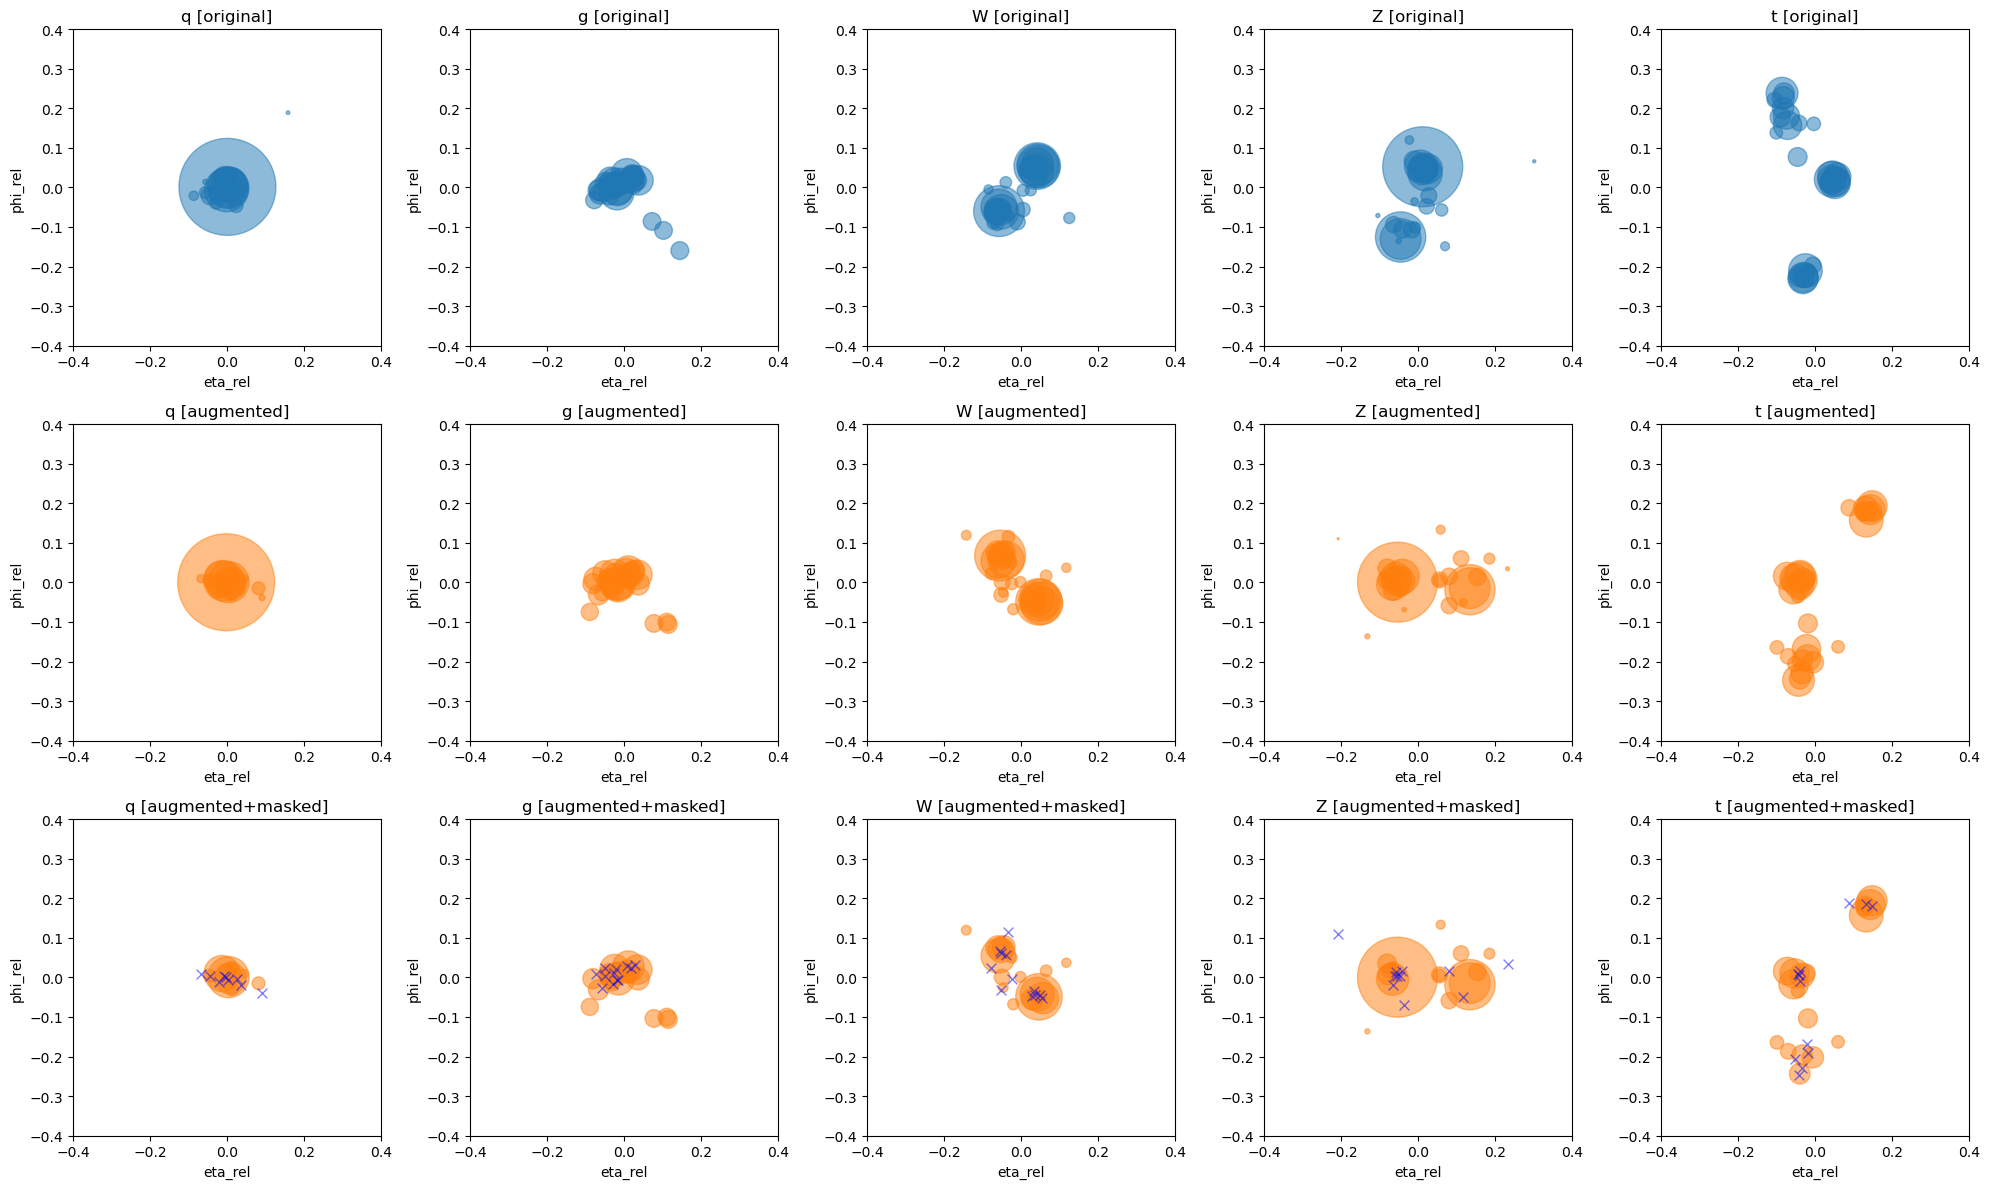

In [4]:
RNG = np.random.default_rng(42)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
class_names = ['q', 'g', 'W', 'Z', 't']
mask_ratio = 0.4

for col, cname in enumerate(class_names):
    idx = np.where(y_train.argmax(axis=1)==col)[0][0]
    jet_orig = x_train[idx]

    # original
    eta, phi, pt, valid = jet_orig.T
    axes[0, col].scatter(eta[valid==1], phi[valid==1], color='C0', s=pt[valid==1]*1e4, alpha=0.5)
    axes[0, col].set_title(f"{cname} [original]")

    # augmented
    jet_aug = augment_jet(jet_orig)
    eta, phi, pt, valid = jet_aug.T
    axes[1, col].scatter(eta[valid==1], phi[valid==1], color='C1', s=pt[valid==1]*1e4, alpha=0.5)
    axes[1, col].set_title(f"{cname} [augmented]")

    # augmented + masks
    eta, phi, pt, valid = jet_aug.T
    valid_idx = np.where(valid==1)[0]
    n_valid = valid_idx.size
    n_mask = max(1, int(np.ceil(mask_ratio * n_valid)))
    mask_idx = RNG.choice(valid_idx, n_mask, replace=False)

    mask_bool = np.zeros_like(pt, dtype=bool)
    mask_bool[mask_idx] = True

    pt_masked = pt.copy()
    pt_masked[mask_bool] = 0

    unmasked = (valid==1) & (~mask_bool)
    masked = (valid==1) & mask_bool

    axes[2, col].scatter(eta[unmasked], phi[unmasked], color='C1', s=pt_masked[unmasked]*1e4, alpha=0.5)
    axes[2, col].scatter(eta[masked], phi[masked], marker='x', color='blue', s=50, linewidths=1, alpha=0.5)
    axes[2, col].set_title(f"{cname} [augmented+masked]")

    for row in range(3):
        axes[row, col].set_xlim(-0.4, 0.4)
        axes[row, col].set_ylim(-0.4, 0.4)
        axes[row, col].set_xlabel("eta_rel")
        axes[row, col].set_ylabel("phi_rel")

plt.tight_layout()
plt.show()

## build ibot model

In [5]:
class AddClsToken(Layer):
    # add [CLS] token: (batch, n_tokens, d_model) -> (batch, n_tokens+1, d_model)
    def __init__(self, d_model, **kw):
        super().__init__(**kw)
        self.cls = self.add_weight(name="cls_token", shape=(1, 1, d_model), initializer="zeros", trainable=True)

    def call(self, x):
        # tile along the batch dimension
        cls_token = tf.tile(self.cls, [tf.shape(x)[0], 1, 1])
        return tf.concat([cls_token, x], axis=1)

class TransformerBlock(Layer):
    def __init__(self, d_model, n_heads, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(n_heads, d_model//n_heads)
        self.ln1 = LayerNormalization(epsilon=1e-6)
        self.ln2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([Dense(4*d_model, activation='relu'), Dense(d_model)])
        self.drop1 = Dropout(0.2)
        self.drop2 = Dropout(0.2)

    def call(self, x):
        attn_out = self.mha(x, x)
        attn_out = self.ln1(x + self.drop1(attn_out))

        ffn_out = self.ffn(attn_out)
        ffn_out = self.ln2(attn_out + self.drop2(ffn_out))
        return ffn_out

def build_backbone(d_model, n_heads, n_layers, name="backbone"):
    x_in = keras.Input((30, 4), name='particles_in') 

    # linear projection for token embedding
    x = Dense(d_model, name="token_embedding")(x_in)

    # prepend [CLS] token
    x = AddClsToken(d_model, name="prepend_cls")(x)

    # transformer blocks
    for i in range(n_layers):
        x = TransformerBlock(d_model, n_heads, name=f"block_{i}")(x)

    # split CLS and patch (particle) outputs
    cls_out = x[:, 0]
    particle_out = x[:, 1:]
    return keras.Model(x_in, [cls_out, particle_out], name=name)

def build_proj_head(d_in, d_proj, name):
    head = keras.Sequential([
        Dense(d_proj, activation='relu'),
        Dense(d_proj),
        Lambda(lambda t: tf.math.l2_normalize(t, -1))
    ], name=name)
    head.build((None, None, d_in))
    return head

d_model=64
n_heads=5
n_layers=5
d_proj=32

student = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)
teacher = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)

proj_head_s = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_student")
proj_head_t = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_teacher")

teacher.set_weights(student.get_weights())
proj_head_t.set_weights(proj_head_s.get_weights())
teacher.trainable = False
proj_head_t.trainable = False

print(student.summary())
print(proj_head_s.summary())

2025-08-28 13:54:39.889639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79193 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Model: "backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ particles_in        │ (None, 30, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 30, 64)    │        320 │ particles_in[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prepend_cls         │ (None, 31, 64)    │         64 │ token_embedding[… │
│ (AddClsToken)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0             │ (None, 31, 64)    │     48,948 │ prepend_cls[0][0] │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1             │ (None, 31, 64)    │     48,948 │ block_0[0][0]     │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2             │ (None, 31, 64)    │     48,948 │ block_1[0][0]     │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_3             │ (None, 31, 64)    │     48,948 │ block_2[0][0]     │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4             │ (None, 31, 64)    │     48,948 │ block_3[0][0]     │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64)        │          0 │ block_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 30, 64)    │          0 │ block_4[0][0]     │
│ (GetItem)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,124 (957.52 KB)

 Trainable params: 245,124 (957.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "proj_head_student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, None, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, None, 32)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,136 (12.25 KB)

 Trainable params: 3,136 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# wrappers for tf.data
def tf_augment_batch(jets):
    def aug_(j):
        out = tf.numpy_function(augment_jet, [j], tf.float32)
        out.set_shape((30, 4))
        return out
    return tf.map_fn(aug_, jets, fn_output_signature=tf.TensorSpec((30,4), tf.float32))

def tf_make_masks(jets, mask_ratio_ibot):
    def mask_(jet):
        eta, phi, pt, valid = tf.unstack(jet, axis=1)
        valid_idx = tf.where(tf.equal(valid, 1.0))[:, 0]
        n_valid = tf.size(valid_idx)
        n_mask = tf.maximum(1, tf.cast(tf.math.ceil(mask_ratio_ibot * tf.cast(n_valid, tf.float32)), tf.int32))
        mask_idx = tf.random.shuffle(valid_idx)[:n_mask]
        mask_bool = tf.scatter_nd(tf.expand_dims(mask_idx, 1), tf.ones_like(mask_idx, tf.bool), [30])
        return mask_bool

    masks = tf.map_fn(mask_, jets, fn_output_signature=tf.TensorSpec((30,), tf.bool))
    return masks

# centering for teacher logits
def update_center(tok_cls, tok_patch, center_cls, center_patch, center_beta):
    center_cls.assign(center_beta * center_cls + (1 - center_beta) * tf.reduce_mean(tok_cls, axis=0))
    center_patch.assign(center_beta * center_patch + (1 - center_beta) * tf.reduce_mean(tok_patch, axis=[0, 1]))

# loss def
def softmax_temp(x, t):
    return tf.nn.softmax(x/t, axis=-1)

def ce_teacher_student(t_logits, s_logits, temp_t=0.04, temp_s=0.1):
    p_t = tf.stop_gradient(softmax_temp(t_logits, temp_t))
    log_p_s = tf.nn.log_softmax(s_logits / temp_s, axis=-1)
    cross_entropy = -tf.reduce_mean(tf.reduce_sum(p_t * log_p_s, axis=-1))
    return cross_entropy

def ibot_loss(cls_s, cls_t, patch_s, patch_t, mask_bool, center_cls, center_patch):
    # CLS
    loss_cls = ce_teacher_student(cls_t - center_cls, cls_s)

    # masked tokens
    float_mask = tf.cast(mask_bool, tf.float32)[..., None]
    patch_s = patch_s * float_mask
    patch_t = (patch_t - center_patch) * float_mask

    # flatten everything
    patch_s_flat = tf.reshape(patch_s, [-1, d_proj])
    patch_t_flat = tf.reshape(patch_t, [-1, d_proj])
    bool_flat  = tf.reshape(mask_bool, [-1])

    # keep only masked positions
    patch_s_sel = tf.boolean_mask(patch_s_flat, bool_flat)
    patch_t_sel = tf.boolean_mask(patch_t_flat, bool_flat)

    loss_tok = ce_teacher_student(patch_t_sel, patch_s_sel)
    return loss_cls + loss_tok, loss_cls, loss_tok

In [7]:
def train_ibot(x_train, epochs, batch_size, optimizer, ema_tau,
               student, teacher, proj_head_s, proj_head_t,
               mask_ratio_ibot, masker, center_cls, center_patch,
               center_beta, temp_t, temp_s):

    token_emb_layer = student.get_layer("token_embedding")
    prepend_cls_layer = student.get_layer("prepend_cls")
    blocks = [student.get_layer(f"block_{i}") for i in range(n_layers)]

    def ema_update(ema_tau=ema_tau):
        for s, t in zip(student.weights, teacher.weights):
            t.assign(ema_tau * t + (1 - ema_tau) * s)
        for s, t in zip(proj_head_s.weights, proj_head_t.weights):
            t.assign(ema_tau * t + (1 - ema_tau) * s)

    @tf.function
    def train_step(ds_jets, optimizer, student, teacher, proj_head_s, proj_head_t, masker):
        # two augmented views
        jet_u = tf_augment_batch(ds_jets)
        jet_v = tf_augment_batch(ds_jets)

        # tokens to mask
        mask_u = tf_make_masks(jet_u, mask_ratio_ibot)
        mask_v = tf_make_masks(jet_v, mask_ratio_ibot)

        with tf.GradientTape() as tape:
            # student: replace masked tokens with learnable mask vector
            emb_u = token_emb_layer(jet_u)
            emb_v = token_emb_layer(jet_v)
            emb_u_masked = masker(emb_u, mask_u)
            emb_v_masked = masker(emb_v, mask_v)

            xu = prepend_cls_layer(emb_u_masked)
            xv = prepend_cls_layer(emb_v_masked)
            for blk in blocks:
                xu = blk(xu)
                xv = blk(xv)

            cls_u_s, patch_u_s = xu[:, 0], xu[:, 1:]
            cls_v_s, patch_v_s = xv[:, 0], xv[:, 1:]

            # projections
            cls_u_s = proj_head_s(tf.expand_dims(cls_u_s, 1))[:, 0, :]
            cls_v_s = proj_head_s(tf.expand_dims(cls_v_s, 1))[:, 0, :]
            patch_u_s = proj_head_s(patch_u_s)
            patch_v_s = proj_head_s(patch_v_s)

            # teacher
            cls_u_t, patch_u_t = teacher(jet_u, training=False)
            cls_v_t, patch_v_t = teacher(jet_v, training=False)
            cls_u_t = proj_head_t(tf.expand_dims(cls_u_t, 1))[:, 0, :]
            cls_v_t = proj_head_t(tf.expand_dims(cls_v_t, 1))[:, 0, :]
            patch_u_t = proj_head_t(patch_u_t)
            patch_v_t = proj_head_t(patch_v_t)

            # loss
            loss_uv, loss_cls_uv, loss_patch_uv = ibot_loss(
                cls_s=cls_u_s, cls_t=cls_v_t,
                patch_s=patch_u_s, patch_t=patch_v_t,
                mask_bool=mask_u, center_cls=center_cls, center_patch=center_patch
            )
            loss_vu, loss_cls_vu, loss_patch_vu = ibot_loss(
                cls_s=cls_v_s, cls_t=cls_u_t,
                patch_s=patch_v_s, patch_t=patch_u_t,
                mask_bool=mask_v, center_cls=center_cls, center_patch=center_patch
            )
            loss = 0.5 * (loss_uv + loss_vu)
            loss_cls = 0.5 * (loss_cls_uv + loss_cls_vu)
            loss_patch = 0.5 * (loss_patch_uv + loss_patch_vu)

            # optional can remove?
            #loss += 1e-7 * tf.reduce_sum(masker.mask_token ** 2)

        vars_ = student.trainable_weights + proj_head_s.trainable_weights + masker.trainable_weights
        grads = tape.gradient(loss, vars_)
        grads_vars = [(g, v) for g, v in zip(grads, vars_) if g is not None]
        if grads_vars:
            optimizer.apply_gradients(grads_vars)

        # entropy
        z_t = tf.concat([cls_u_t, cls_v_t], axis=0)
        prob_t = tf.nn.softmax((z_t - center_cls)[...] / temp_t, axis=-1)
        entropy_teacher = -tf.reduce_mean(tf.reduce_sum(prob_t * tf.math.log(prob_t + 1e-9), axis=-1))
        prob_s = tf.nn.softmax((cls_u_s + cls_v_s) / 2 / temp_s, axis=-1)
        entropy_student = -tf.reduce_mean(tf.reduce_sum(prob_s * tf.math.log(prob_s + 1e-9), axis=-1))

        # centers
        update_center(
            tok_cls=tf.stop_gradient(tf.concat([cls_u_t, cls_v_t], 0)),
            tok_patch=tf.stop_gradient(tf.concat([patch_u_t, patch_v_t], 0)),
            center_cls=center_cls, center_patch=center_patch, center_beta=center_beta
        )
        return loss, loss_cls, loss_patch, entropy_teacher, entropy_student

    history = {
        "loss_total": [], "loss_cls": [], "loss_patch": [],
        "entropy_teacher": [], "entropy_student": [],
        "center_cls": [], "center_patch": [],
        "mask_token": []
    }

    ds = (tf.data.Dataset.from_tensor_slices(x_train.astype("float32"))
          .shuffle(x_train.shape[0], seed=42)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))

    steps_per_epoch = math.ceil(x_train.shape[0] / batch_size)
    
    for epoch in range(epochs):
        print(f"epoch {epoch+1}/{epochs}")
        prog = Progbar(target=steps_per_epoch, interval=0.1, unit_name="step")
        
        ema_tau_waved = 1 - (1 - ema_tau) * (1 + math.cos(math.pi * epoch / epochs)) / 2
        L_total, L_cls, L_patch, E_teacher, E_student = [], [], [], [], []
        
        step = 0
        for ds_jets in ds:
            l_total, l_cls, l_patch, e_teacher, e_student = train_step(
                ds_jets=ds_jets, optimizer=optimizer,
                student=student, teacher=teacher,
                proj_head_s=proj_head_s, proj_head_t=proj_head_t,
                masker=masker
            )
            ema_update(ema_tau_waved)

            ll_total = float(l_total.numpy())
            ll_cls = float(l_cls.numpy())
            ll_patch = float(l_patch.numpy())
            
            L_total.append(l_total.numpy())
            L_cls.append(l_cls.numpy())
            L_patch.append(l_patch.numpy())
            E_teacher.append(e_teacher.numpy())
            E_student.append(e_student.numpy())

            step += 1
            prog.update(step, values=[("loss", ll_total), ("cls", ll_cls), ("patch", ll_patch)])

        history["loss_total"].append(np.mean(L_total))
        history["loss_cls"].append(np.mean(L_cls))
        history["loss_patch"].append(np.mean(L_patch))
        history["entropy_teacher"].append(np.mean(E_teacher))
        history["entropy_student"].append(np.mean(E_student))
        history["center_cls"].append(np.linalg.norm(center_cls.numpy()))
        history["center_patch"].append(np.linalg.norm(center_patch.numpy()))
        history["mask_token"].append(np.linalg.norm(masker.mask_token.numpy()))

        print(f"epoch {epoch+1}/{epochs} | "
              f"loss(total)={history['loss_total'][-1]:.3f}; "
              f"loss(cls)={history['loss_cls'][-1]:.3f}; "
              f"loss(patch)={history['loss_patch'][-1]:.3f}; "
              f"entropy(teacher)={history['entropy_teacher'][-1]:.3f}; "
              f"entropy(student)={history['entropy_student'][-1]:.3f}; "
              f"norm(center_cls)={history['center_cls'][-1]:.3f}; "
              f"norm(center_patch)={history['center_patch'][-1]:.3f}; "
              f"norm(mask_token)={history['mask_token'][-1]:.3f}")
    return history


class MaskTokens(keras.layers.Layer):
    def __init__(self, d_model, init_std=0.02, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.init_std = init_std

    def build(self, input_shape):
        self.mask_token = self.add_weight(
            name="mask_token",
            shape=(self.d_model,),
            initializer=keras.initializers.RandomNormal(stddev=self.init_std),
            trainable=True,
        )
        super().build(input_shape)

    def call(self, embeddings, mask_bool):
        float_mask = tf.cast(mask_bool, embeddings.dtype)[..., None]
        return embeddings * (1.0 - float_mask) + self.mask_token[None, None, :] * float_mask
        
masker = MaskTokens(d_model, name="particle_masker")

center_cls = tf.Variable(tf.zeros([d_proj]), trainable=False)
center_patch = tf.Variable(tf.zeros([d_proj]), trainable=False)

history_ibot_5class = train_ibot(x_train=x_train,
                                 epochs=30,
                                 batch_size=256,
                                 #optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
                                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                                 ema_tau=0.996,
                                 student=student,
                                 teacher=teacher,
                                 proj_head_s=proj_head_s,
                                 proj_head_t=proj_head_t,
                                 mask_ratio_ibot=0.4,
                                 masker=masker,
                                 center_cls=center_cls,
                                 center_patch=center_patch,
                                 center_beta=0.9,
                                 temp_t=0.04,
                                 temp_s=0.1)

epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 434s 534ms/step - loss: 5.4452 - cls: 2.6950 - patch: 2.7502
epoch 1/30 | loss(total)=5.445; loss(cls)=2.695; loss(patch)=2.750; entropy(teacher)=2.662; entropy(student)=2.676; norm(center_cls)=0.721; norm(center_patch)=0.704; norm(mask_token)=0.187
epoch 2/30


2025-08-28 14:02:01.270195: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


782/782 ━━━━━━━━━━━━━━━━━━━━ 411s 526ms/step - loss: 5.6461 - cls: 2.8191 - patch: 2.8270
epoch 2/30 | loss(total)=5.646; loss(cls)=2.819; loss(patch)=2.827; entropy(teacher)=2.792; entropy(student)=2.826; norm(center_cls)=0.686; norm(center_patch)=0.671; norm(mask_token)=0.191
epoch 3/30


2025-08-28 14:08:52.462313: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


782/782 ━━━━━━━━━━━━━━━━━━━━ 410s 524ms/step - loss: 4.8204 - cls: 2.4126 - patch: 2.4078
epoch 3/30 | loss(total)=4.820; loss(cls)=2.413; loss(patch)=2.408; entropy(teacher)=2.252; entropy(student)=2.437; norm(center_cls)=0.748; norm(center_patch)=0.742; norm(mask_token)=0.192
epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 410s 524ms/step - loss: 3.6518 - cls: 1.8364 - patch: 1.8155
epoch 4/30 | loss(total)=3.652; loss(cls)=1.836; loss(patch)=1.815; entropy(teacher)=1.659; entropy(student)=1.871; norm(center_cls)=0.618; norm(center_patch)=0.584; norm(mask_token)=0.192
epoch 5/30


2025-08-28 14:22:32.707065: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


782/782 ━━━━━━━━━━━━━━━━━━━━ 408s 521ms/step - loss: 2.1245 - cls: 0.9665 - patch: 1.1580
epoch 5/30 | loss(total)=2.125; loss(cls)=0.966; loss(patch)=1.158; entropy(teacher)=0.719; entropy(student)=1.050; norm(center_cls)=0.623; norm(center_patch)=0.554; norm(mask_token)=0.192
epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 409s 523ms/step - loss: 1.5627 - cls: 0.5886 - patch: 0.9741
epoch 6/30 | loss(total)=1.563; loss(cls)=0.589; loss(patch)=0.974; entropy(teacher)=0.296; entropy(student)=0.676; norm(center_cls)=0.605; norm(center_patch)=0.491; norm(mask_token)=0.193
epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 409s 523ms/step - loss: 1.4718 - cls: 0.4663 - patch: 1.0055
epoch 7/30 | loss(total)=1.472; loss(cls)=0.466; loss(patch)=1.006; entropy(teacher)=0.194; entropy(student)=0.549; norm(center_cls)=0.600; norm(center_patch)=0.480; norm(mask_token)=0.193
epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 414s 529ms/step - loss: 1.2365 - cls: 0.3600 - patch: 0.8765
epoch 8/30 | loss(total)=1.237; loss(cls

2025-08-28 14:49:52.887736: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


782/782 ━━━━━━━━━━━━━━━━━━━━ 412s 527ms/step - loss: 1.0828 - cls: 0.3177 - patch: 0.7651
epoch 9/30 | loss(total)=1.083; loss(cls)=0.318; loss(patch)=0.765; entropy(teacher)=0.123; entropy(student)=0.374; norm(center_cls)=0.552; norm(center_patch)=0.440; norm(mask_token)=0.198
epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 411s 523ms/step - loss: 1.0500 - cls: 0.3119 - patch: 0.7381
epoch 10/30 | loss(total)=1.050; loss(cls)=0.312; loss(patch)=0.738; entropy(teacher)=0.122; entropy(student)=0.366; norm(center_cls)=0.539; norm(center_patch)=0.435; norm(mask_token)=0.201
epoch 11/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 412s 527ms/step - loss: 0.9886 - cls: 0.3023 - patch: 0.6863
epoch 11/30 | loss(total)=0.989; loss(cls)=0.302; loss(patch)=0.686; entropy(teacher)=0.119; entropy(student)=0.353; norm(center_cls)=0.530; norm(center_patch)=0.438; norm(mask_token)=0.204
epoch 12/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 412s 527ms/step - loss: 0.9647 - cls: 0.3116 - patch: 0.6531
epoch 12/30 | loss(total)=0.965; lo

2025-08-28 15:44:42.166505: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


782/782 ━━━━━━━━━━━━━━━━━━━━ 411s 526ms/step - loss: 1.0500 - cls: 0.3577 - patch: 0.6923
epoch 17/30 | loss(total)=1.050; loss(cls)=0.358; loss(patch)=0.692; entropy(teacher)=0.137; entropy(student)=0.409; norm(center_cls)=0.522; norm(center_patch)=0.455; norm(mask_token)=0.196
epoch 18/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 412s 527ms/step - loss: 1.0478 - cls: 0.3650 - patch: 0.6828
epoch 18/30 | loss(total)=1.048; loss(cls)=0.365; loss(patch)=0.683; entropy(teacher)=0.141; entropy(student)=0.417; norm(center_cls)=0.520; norm(center_patch)=0.459; norm(mask_token)=0.199
epoch 19/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 417s 533ms/step - loss: 1.0465 - cls: 0.3792 - patch: 0.6673
epoch 19/30 | loss(total)=1.046; loss(cls)=0.379; loss(patch)=0.667; entropy(teacher)=0.144; entropy(student)=0.431; norm(center_cls)=0.522; norm(center_patch)=0.459; norm(mask_token)=0.193
epoch 20/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 414s 528ms/step - loss: 1.0438 - cls: 0.3887 - patch: 0.6551
epoch 20/30 | loss(total)=1.044; l

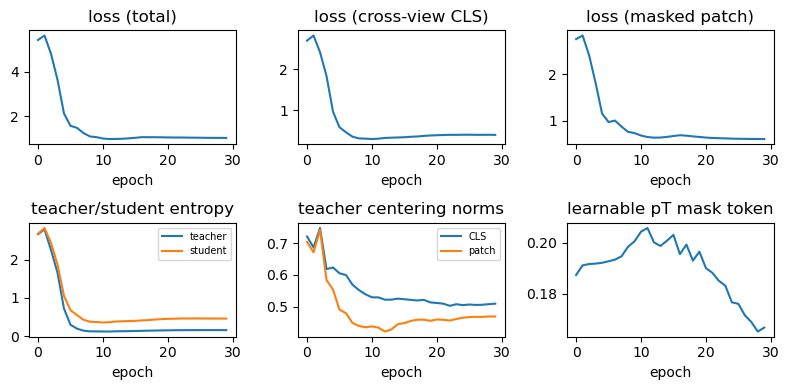

In [8]:
def plot_ibot_training(history):
    fig, ax = plt.subplots(2, 3, figsize=(8, 4), sharex=False)
    ax[0,0].plot(history["loss_total"])
    ax[0,0].set_title("loss (total)")
    ax[0,0].set_xlabel("epoch")

    ax[0,1].plot(history["loss_cls"])
    ax[0,1].set_title("loss (cross-view CLS)")
    ax[0,1].set_xlabel("epoch")

    ax[0,2].plot(history["loss_patch"])
    ax[0,2].set_title("loss (masked patch)")
    ax[0,2].set_xlabel("epoch")

    ax[1,0].plot(history["entropy_teacher"], label="teacher")
    ax[1,0].plot(history["entropy_student"], label="student")
    ax[1,0].set_title("teacher/student entropy")
    ax[1,0].set_xlabel("epoch")
    ax[1,0].legend(fontsize=7)

    ax[1,1].plot(history["center_cls"], label="CLS")
    ax[1,1].plot(history["center_patch"], label="patch")
    ax[1,1].set_title("teacher centering norms")
    ax[1,1].set_xlabel("epoch")
    ax[1,1].legend(fontsize=7)

    ax[1,2].plot(history["mask_token"])
    ax[1,2].set_title("learnable pT mask token")
    ax[1,2].set_xlabel("epoch")
    plt.tight_layout()
    plt.show()

plot_ibot_training(history_ibot_5class)

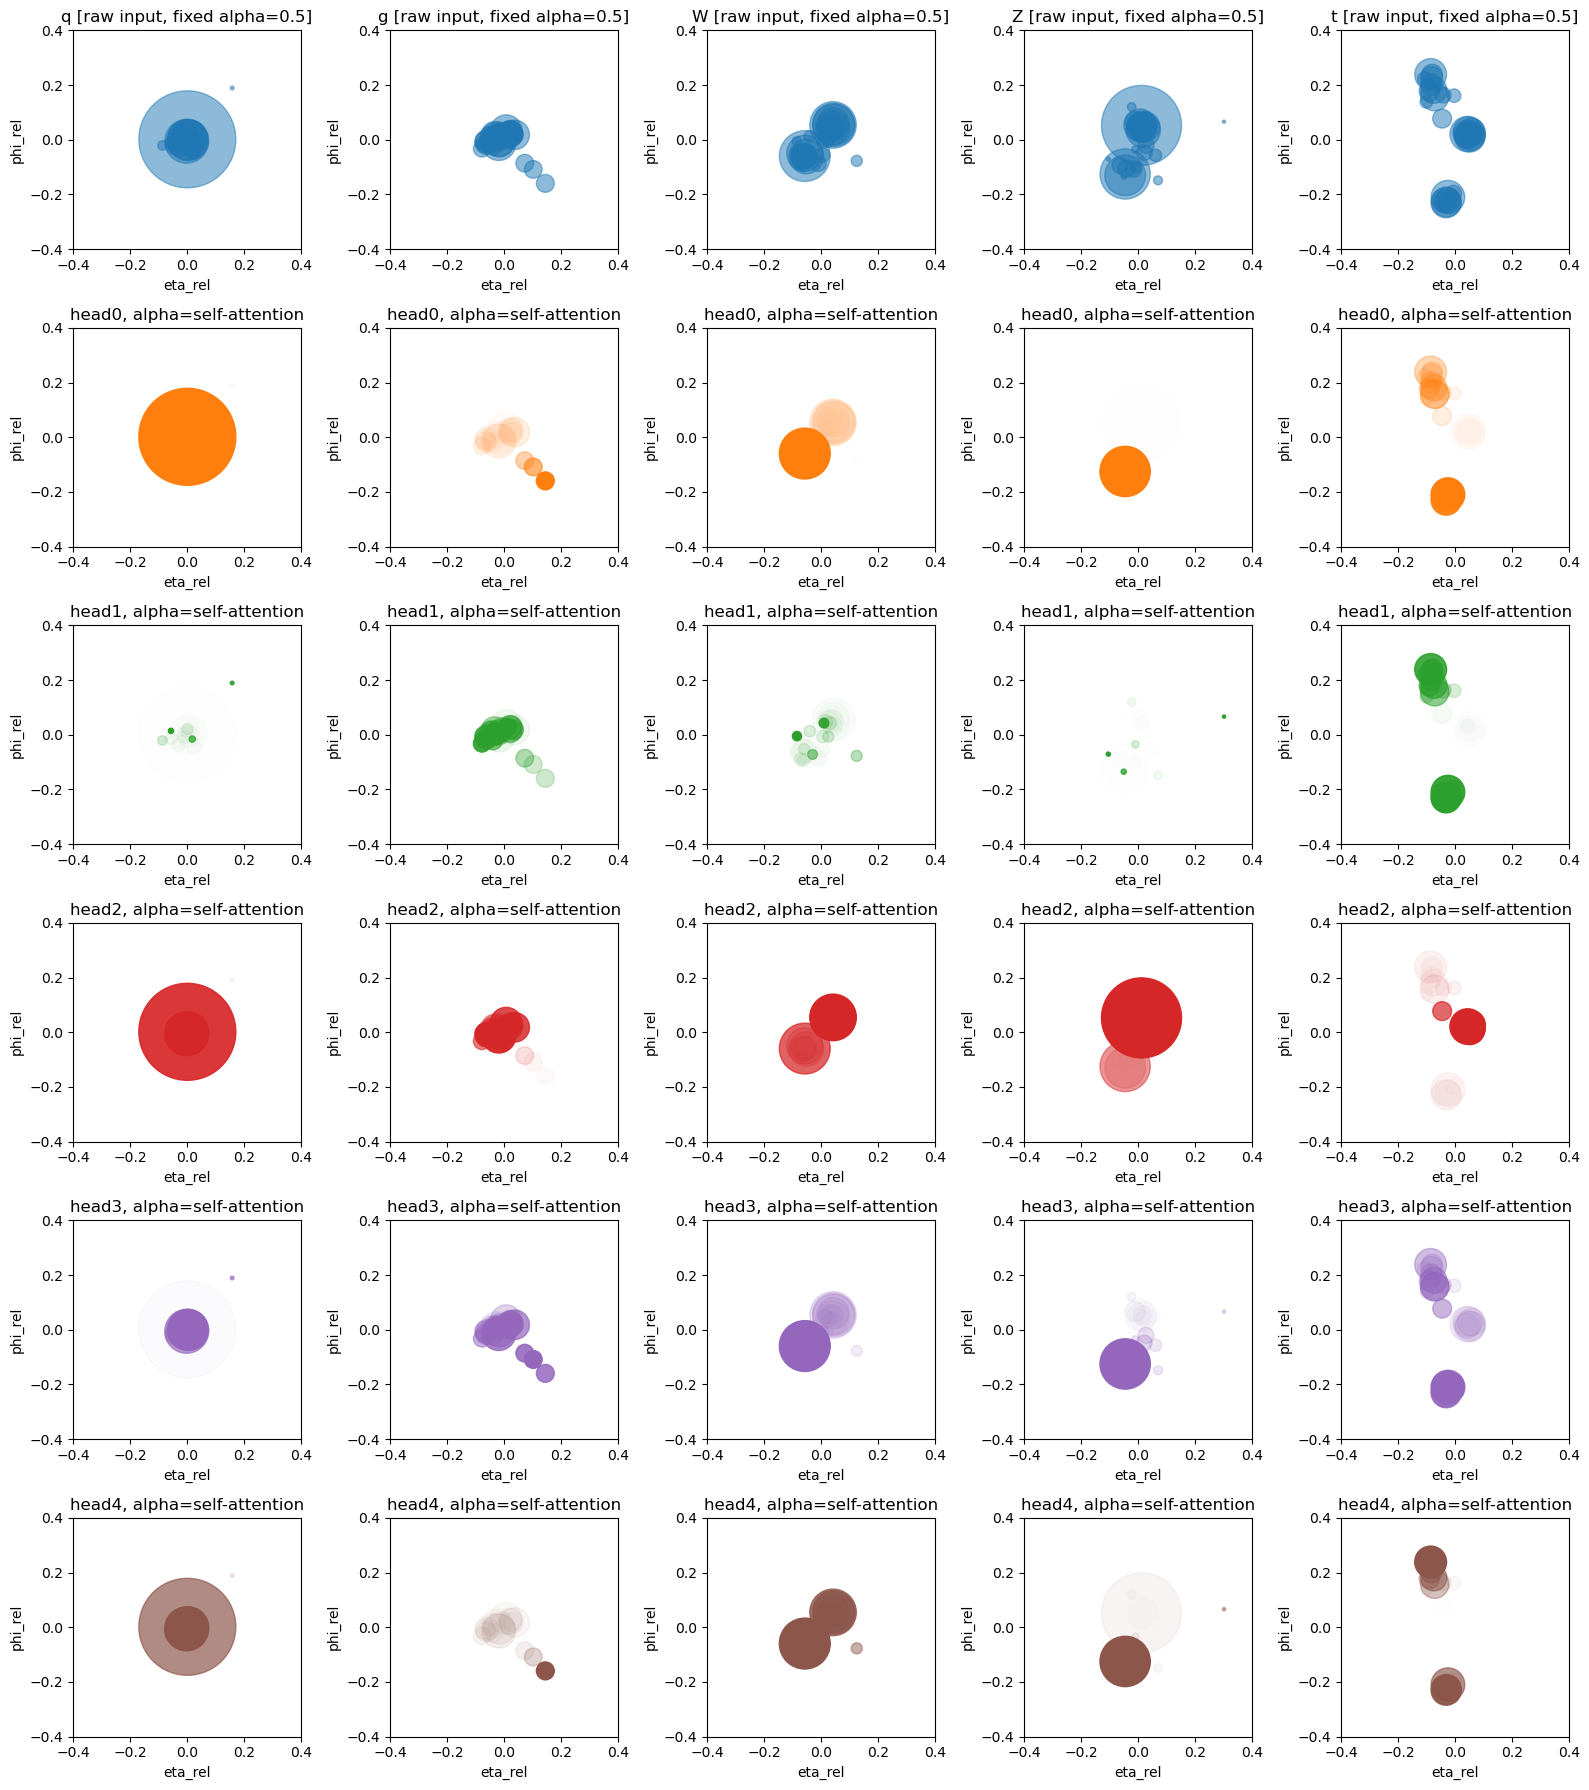

In [ ]:
def plot_attention(transformer, n_heads, n_layers):
    last_block = transformer.get_layer(f"block_{n_layers-1}")
    mha_last = last_block.mha
    #heads = getattr(mha_last, "num_heads", getattr(mha_last, "_num_heads"))

    # rebuild model with attention scores as output
    x_in = transformer.input
    x = transformer.get_layer("token_embedding")(x_in)
    x = transformer.get_layer("prepend_cls")(x)
    for i in range(n_layers-1):
        x = transformer.get_layer(f"block_{i}")(x)
    _, attn_scores = mha_last(x, x, return_attention_scores=True)
    model_re = tf.keras.Model(x_in, attn_scores)

    class_names = ['q', 'g', 'W', 'Z', 't']
    rows = 1 + n_heads
    fig, axes = plt.subplots(rows, 5, figsize=(16, 3*rows))

    for col, cname in enumerate(class_names):
        idx = np.where(y_train.argmax(axis=1)==col)[0][0]
        jet = x_train[idx][None, ...].astype("float32") # (1,30,4)
        scores = model_re(jet).numpy()[0] # (n_heads, 31, 31)
        QUERYcls_KEYpatch = scores[:, 0, 1:] # (n_heads, 30)

        eta, phi, pt, valid = jet[0].T
        eta, phi, pt = eta[valid==1], phi[valid==1], pt[valid==1]
        QUERYcls_KEYpatch = QUERYcls_KEYpatch[:, valid==1]

        ax0 = axes[0, col]
        ax0.scatter(eta, phi, color="C0", s=pt*1e4, alpha=0.5)
        ax0.set_title(f"{cname} [raw input, fixed alpha=0.5]")
        ax0.set_xlim(-0.4, 0.4)
        ax0.set_ylim(-0.4, 0.4)

        for h in range(n_heads):
            w = QUERYcls_KEYpatch[h]
            w = (w - w.min())/(w.ptp() + 1e-8) # normalized
            ax = axes[1+h, col]
            ax.scatter(eta, phi, color=f"C{h+1}", s=pt*1e4, alpha=w)
            if col==0: ax.set_ylabel(f"head {h}")
            ax.set_title(f"head{h}, alpha=self-attention")
            ax.set_xlim(-0.4, 0.4)
            ax.set_ylim(-0.4, 0.4)

    for r in range(rows):
        for c in range(5):
            axes[r,c].set_xlabel("eta_rel")
            axes[r,c].set_ylabel("phi_rel")

    plt.tight_layout()
    plt.show()

plot_attention(transformer=student, n_heads=n_heads, n_layers=n_layers)

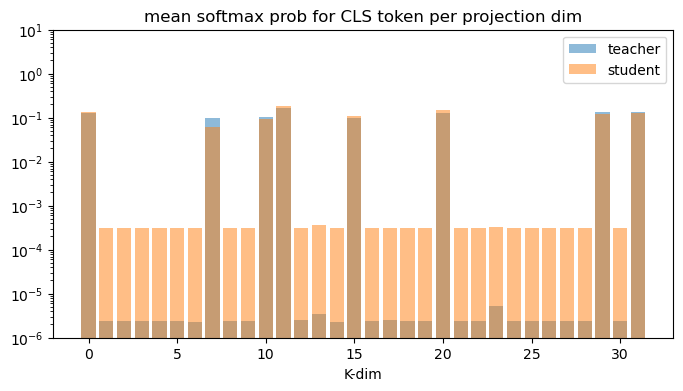

In [ ]:
def plot_softmax_prob_cls(n_samples, student, teacher, proj_head_s, proj_head_t, center_cls, temp_t, temp_s):
    x_sample = x_test[:n_samples].astype("float32")

    cls_t, _ = teacher(x_sample, training=False)
    z_teacher = proj_head_t(tf.expand_dims(cls_t, 1))[:, 0, :]
    prob_t = tf.nn.softmax((z_teacher - center_cls) / temp_t, axis=-1)
    mean_prob_t = tf.reduce_mean(prob_t, axis=0).numpy()

    cls_s, _ = student(x_sample, training=False)
    z_student = proj_head_s(tf.expand_dims(cls_s, 1))[:, 0, :]
    prob_s = tf.nn.softmax(z_student / temp_s, axis=-1)
    mean_prob_s = tf.reduce_mean(prob_s, axis=0).numpy()

    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(z_teacher.shape[-1]), mean_prob_t, label="teacher", alpha=0.5)
    plt.bar(np.arange(z_student.shape[-1]), mean_prob_s, label="student", alpha=0.5)
    plt.yscale("log")
    plt.ylim(1e-6, 10)
    plt.legend()
    plt.title("mean softmax prob for CLS token per projection dim")
    plt.xlabel("K-dim")

plot_softmax_prob_cls(n_samples=5000,
                      student=student, teacher=teacher,
                      proj_head_s=proj_head_s, proj_head_t=proj_head_t,
                      center_cls=center_cls, temp_t=0.04, temp_s=0.1)

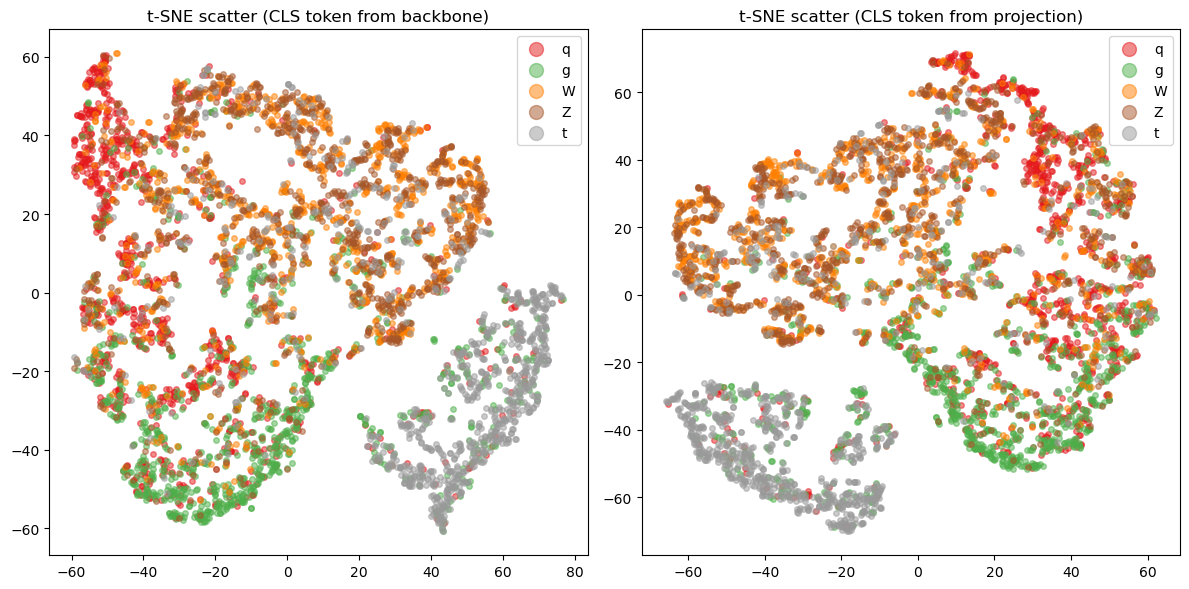

In [ ]:
def plot_tSNE_cls(n_samples, student, proj_head_s):
    x_sample = x_train[:n_samples].astype("float32")
    y_sample = y_train[:n_samples].argmax(1)
    palette = plt.cm.Set1(np.linspace(0, 1, 5))
    class_names = ['q', 'g', 'W', 'Z', 't']

    cls_s, _ = student(x_sample, training=False)
    z_backbone = cls_s.numpy()  # (N, d_model)

    tsne_backbone = TSNE(n_components=2, random_state=42).fit_transform(z_backbone)

    tsne_projection = None
    if proj_head_s is not None:
        z_projection = proj_head_s(tf.expand_dims(cls_s, 1))[:, 0, :]  # (N, d_proj)
        z_projection = z_projection.numpy()
        tsne_projection = TSNE(n_components=2, random_state=42).fit_transform(z_projection)

    fig, ax = plt.subplots(1, 2 if tsne_projection is not None else 1, figsize=(12, 6))

    ax0 = ax[0] if isinstance(ax, np.ndarray) else ax
    for k, c in enumerate(class_names):
        ax0.scatter(tsne_backbone[y_sample == k, 0], tsne_backbone[y_sample == k, 1],
                    s=16, label=c, color=palette[k], alpha=0.5)
    ax0.set_title("t-SNE scatter (CLS token from backbone)")
    ax0.legend(markerscale=2.5)

    if tsne_projection is not None and isinstance(ax, np.ndarray):
        for k, c in enumerate(class_names):
            ax[1].scatter(tsne_projection[y_sample == k, 0], tsne_projection[y_sample == k, 1],
                          s=16, label=c, color=palette[k], alpha=0.5)
        ax[1].set_title("t-SNE scatter (CLS token from projection)")
        ax[1].legend(markerscale=2.5)

    plt.tight_layout()
    plt.show()

plot_tSNE_cls(n_samples=5000, student=student, proj_head_s=proj_head_s)

In [ ]:
z_cls_train = student.predict(x_train)[0]
z_cls_test = student.predict(x_test)[0]

y_train_idx = y_train.argmax(1)
y_test_idx = y_test.argmax(1)

knn = KNeighborsClassifier(n_neighbors=20).fit(z_cls_train, y_train_idx)
acc_knn = accuracy_score(y_test_idx, knn.predict(z_cls_test))

scaler = StandardScaler().fit(z_cls_train)
Z_cls_train, Z_cls_test = scaler.transform(z_cls_train), scaler.transform(z_cls_test)
logreg = LogisticRegression(max_iter=1000).fit(Z_cls_train, y_train_idx)
acc_linear = accuracy_score(y_test_idx, logreg.predict(Z_cls_test))

print(f"k-NN acc: {acc_knn:.3f}")
print(f"linear acc: {acc_linear:.3f}")

knn_p = knn.predict_proba(z_cls_test)
linear_p = logreg.predict_proba(Z_cls_test)

I0000 00:00:1756401210.930870  127730 service.cc:146] XLA service 0x7fab980ca720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756401210.930925  127730 service.cc:154]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-08-28 17:13:30.976234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-28 17:13:31.072181: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-08-28 17:13:32.007885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 116 bytes spill stores, 116 bytes spill loads



 131/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

I0000 00:00:1756401213.365920  127730 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
k-NN acc: 0.675
linear acc: 0.677


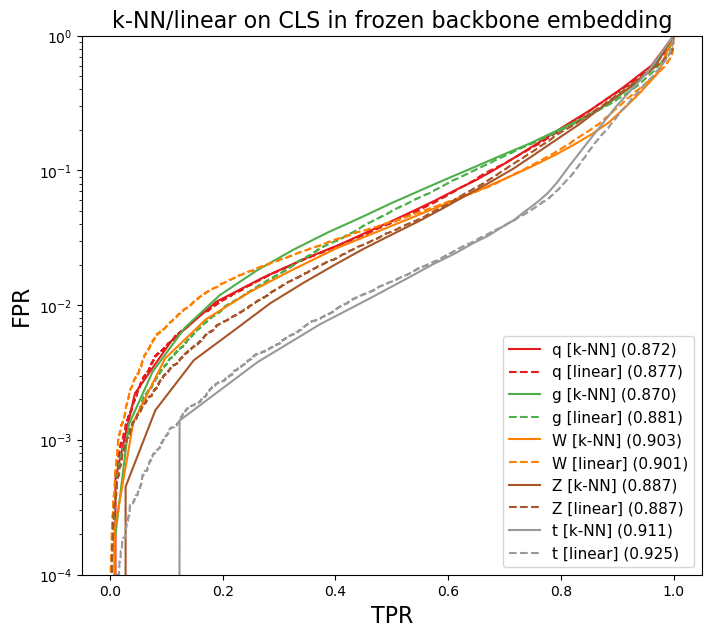

In [ ]:
plt.figure(figsize=(8,7))
colors = plt.cm.Set1(np.linspace(0,1,5))
class_names = ['q','g','W','Z','t']

for k,c in enumerate(class_names):
    fpr_k, tpr_k, _ = roc_curve(y_test[:,k], knn_p[:,k])
    auc_k = auc(fpr_k, tpr_k)
    plt.plot(tpr_k, fpr_k, color=colors[k], label=f"{c} [k-NN] ({auc_k:.3f})", linestyle="-", lw=1.5)

    fpr_l, tpr_l, _ = roc_curve(y_test[:,k], linear_p[:,k])
    auc_l = auc(fpr_l, tpr_l)
    plt.plot(tpr_l, fpr_l, color=colors[k], label=f"{c} [linear] ({auc_l:.3f})", linestyle="--", lw=1.5)

plt.xlabel("TPR", size=16)
plt.ylabel("FPR", size=16)
plt.yscale("log")
plt.ylim(1e-4,1)
plt.title("k-NN/linear on CLS in frozen backbone embedding", size=16)
plt.legend(fontsize=11)
plt.show()

In [ ]:
# --- classifier on backbone embedding (no fine tuning) vs standalone classifier
def build_mlp(dim_in, n_classes=5, name="mlp"):
    x_in = Input(shape=(dim_in,))
    x = Dense(dim_in*3, activation='relu')(x_in)
    x = Dropout(0.2)(x)
    x = Dense(dim_in*3, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(n_classes, activation='softmax')(x)
    return tf.keras.models.Model(x_in, x, name=name)

student.trainable = False
x_in = tf.keras.Input((30,4))
cls, _ = student(x_in)
mlp = build_mlp(d_model, name="mlp_frozen")
x_out = mlp(cls)
model = tf.keras.models.Model(x_in, x_out, name="frozen_backbone_mlp")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

backbone_standalone = build_backbone(d_model, n_heads, n_layers, name="backbone_standalone")
mlp_standalone = build_mlp(d_model, name="mlp_standalone")
x_in = tf.keras.Input((30,4))
cls, _ = backbone_standalone(x_in)
x_out = mlp_standalone(cls)
model_standalone = tf.keras.models.Model(x_in, x_out, name="standalone_backbone_mlp")
model_standalone.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 30
batch = 256
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch)
model_standalone.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch)

Epoch 1/30


2025-08-28 17:14:46.986156: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 20 bytes spill stores, 20 bytes spill loads



781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5408 - loss: 1.1465

2025-08-28 17:14:59.712861: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 116 bytes spill stores, 116 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5408 - loss: 1.1464

2025-08-28 17:15:10.065909: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1049', 20 bytes spill stores, 20 bytes spill loads

2025-08-28 17:15:13.712495: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 116 bytes spill stores, 116 bytes spill loads

2025-08-28 17:15:14.072000: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1049', 68 bytes spill stores, 68 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.5409 - loss: 1.1463 - val_accuracy: 0.6220 - val_loss: 0.9888
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5817 - loss: 1.0688 - val_accuracy: 0.6290 - val_loss: 0.9854
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5850 - loss: 1.0600 - val_accuracy: 0.6300 - val_loss: 0.9809
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5880 - loss: 1.0544 - val_accuracy: 0.6210 - val_loss: 0.9804
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5888 - loss: 1.0515 - val_accuracy: 0.6370 - val_loss: 0.9816
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5918 - loss: 1.0471 - val_accuracy: 0.6440 - val_loss: 0.9652
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5926 - loss: 1.0469 - val_accuracy: 0.6350 - val_loss: 0.9600
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5923 - loss: 1.0457 - val_accuracy: 0.6410 - va

2025-08-28 17:15:58.428258: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134', 68 bytes spill stores, 68 bytes spill loads

2025-08-28 17:15:58.698598: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134', 44 bytes spill stores, 44 bytes spill loads

2025-08-28 17:15:58.744787: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134', 36 bytes spill stores, 36 bytes spill loads



779/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2509 - loss: 1.5625

2025-08-28 17:16:12.513865: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134', 44 bytes spill stores, 44 bytes spill loads

2025-08-28 17:16:12.698909: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_134', 28 bytes spill stores, 28 bytes spill loads



782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.2511 - loss: 1.5623 - val_accuracy: 0.4620 - val_loss: 1.2419
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5812 - loss: 1.0673 - val_accuracy: 0.6760 - val_loss: 0.8421
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6706 - loss: 0.8935 - val_accuracy: 0.7020 - val_loss: 0.7771
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6916 - loss: 0.8441 - val_accuracy: 0.6970 - val_loss: 0.7902
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6978 - loss: 0.8313 - val_accuracy: 0.6860 - val_loss: 0.8174
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7062 - loss: 0.8102 - val_accuracy: 0.7270 - val_loss: 0.7418
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7134 - loss: 0.8004 - val_accuracy: 0.7150 - val_loss: 0.7670
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7135 - loss: 0.7986 - val_accuracy: 0.7010 - va

In [ ]:
backbone_ft = build_backbone(d_model, n_heads, n_layers, name="backbone_finetune")
backbone_ft.set_weights(student.get_weights())
mlp_ft = build_mlp(d_model, name="mlp_finetune")

x_in = tf.keras.Input((30,4))
cls, _ = backbone_ft(x_in)
x_out = mlp_ft(cls)
model_ft = tf.keras.models.Model(x_in, x_out, name="finetune_backbone_mlp")

model_ft.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_ft.fit(x_train, y_train,
             validation_data=(x_val, y_val),
             epochs=2, batch_size=batch)

backbone_ft.trainable = False
model_ft.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_ft.fit(x_train, y_train,
             validation_data=(x_val, y_val),
             initial_epoch=2, epochs=epochs, batch_size=batch)

Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.6501 - loss: 0.9451 - val_accuracy: 0.7340 - val_loss: 0.7268
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7118 - loss: 0.8086 - val_accuracy: 0.7270 - val_loss: 0.7246
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.7305 - loss: 0.7704 - val_accuracy: 0.7470 - val_loss: 0.6947
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7309 - loss: 0.7636 - val_accuracy: 0.7530 - val_loss: 0.6944
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7336 - loss: 0.7592 - val_accuracy: 0.7460 - val_loss: 0.6943
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7311 - loss: 0.7644 - val_accuracy: 0.7490 - val_loss: 0.6894
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7313 - loss: 0.7619 - val_accuracy: 0.7460 - val_loss: 0.6895
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7316 - loss: 0.7625 - val_accuracy: 

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
acc: 0.643
finetune acc: 0.740
standalone acc: 0.744


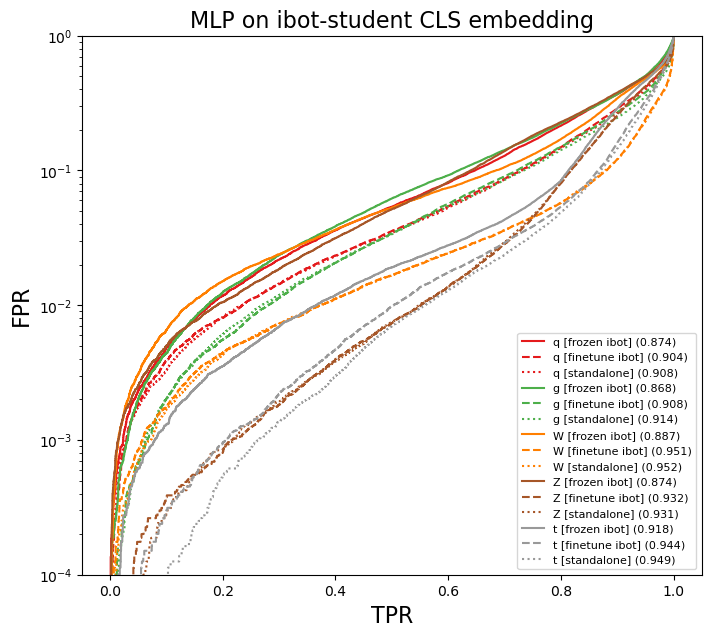

In [ ]:
y_pred = model.predict(x_test)
y_pred_ft = model_ft.predict(x_test)
y_pred_standalone = model_standalone.predict(x_test)

acc_model = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
acc_ft = accuracy_score(y_test.argmax(axis=1), y_pred_ft.argmax(axis=1))
acc_standalone = accuracy_score(y_test.argmax(axis=1), y_pred_standalone.argmax(axis=1))

print(f"acc: {acc_model:.3f}")
print(f"finetune acc: {acc_ft:.3f}")
print(f"standalone acc: {acc_standalone:.3f}")

plt.figure(figsize=(8,7))
colors = plt.cm.Set1(np.linspace(0,1,5))
class_names = ['q','g','W','Z','t']

for k,c in enumerate(class_names):
    fpr_f, tpr_f, _ = roc_curve(y_test[:,k], y_pred[:,k])
    auc_f = auc(fpr_f, tpr_f)
    plt.plot(tpr_f, fpr_f, color=colors[k], lw=1.5, linestyle='-', label=f"{c} [frozen ibot] ({auc_f:.3f})")

    fpr_ft, tpr_ft, _ = roc_curve(y_test[:,k], y_pred_ft[:,k])
    auc_ft = auc(fpr_ft, tpr_ft)
    plt.plot(tpr_ft, fpr_ft, color=colors[k], lw=1.5, linestyle='--', label=f"{c} [finetune ibot] ({auc_ft:.3f})")
    
    fpr_s, tpr_s, _ = roc_curve(y_test[:,k], y_pred_standalone[:,k])
    auc_s = auc(fpr_s, tpr_s)
    plt.plot(tpr_s, fpr_s, color=colors[k], lw=1.5, linestyle='dotted', label=f"{c} [standalone] ({auc_s:.3f})")

plt.xlabel("TPR", size=16)
plt.ylabel("FPR", size=16)
plt.yscale("log")
plt.ylim(1e-4,1)
plt.title("MLP on ibot-student CLS embedding", size=16)
plt.legend(fontsize=8)
plt.show()

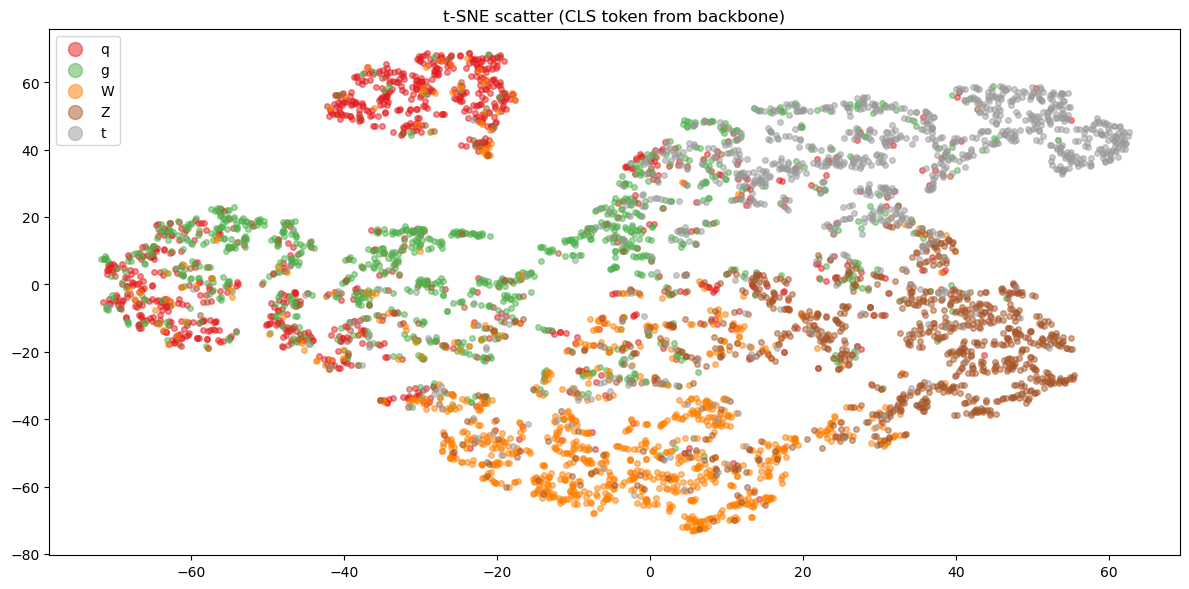

In [ ]:
plot_tSNE_cls(n_samples=5000, student=backbone_ft, proj_head_s=None)

## AD (train ibot with q/g only)

In [ ]:
#d_model=128
#n_heads=3
#n_layers=3
#d_proj=32

student_ad = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)
teacher_ad = build_backbone(d_model=d_model, n_heads=n_heads, n_layers=n_layers)

proj_head_s_ad = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_student")
proj_head_t_ad = build_proj_head(d_in=d_model, d_proj=d_proj, name="proj_head_teacher")

teacher_ad.set_weights(student_ad.get_weights())
proj_head_t_ad.set_weights(proj_head_s_ad.get_weights())
teacher_ad.trainable = False
proj_head_t_ad.trainable = False

print(student_ad.summary())
print(proj_head_s_ad.summary())

Model: "backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ particles_in        │ (None, 30, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_embedding     │ (None, 30, 64)    │        320 │ particles_in[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prepend_cls         │ (None, 31, 64)    │         64 │ token_embedding[… │
│ (AddClsToken)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_0             │ (None, 31, 64)    │     48,948 │ prepend_cls[0][0] │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1             │ (None, 31, 64)    │     48,948 │ block_0[0][0]     │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2             │ (None, 31, 64)    │     48,948 │ block_1[0][0]     │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_3             │ (None, 31, 64)    │     48,948 │ block_2[0][0]     │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4             │ (None, 31, 64)    │     48,948 │ block_3[0][0]     │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 64)        │          0 │ block_4[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 30, 64)    │          0 │ block_4[0][0]     │
│ (GetItem)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,124 (957.52 KB)

 Trainable params: 245,124 (957.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "proj_head_student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, None, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, None, 32)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,136 (12.25 KB)

 Trainable params: 3,136 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

None


epoch 1/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 145s 432ms/step - loss: 5.2180 - cls: 2.5923 - patch: 2.6257
epoch 1/40 | loss(total)=5.218; loss(cls)=2.592; loss(patch)=2.626; entropy(teacher)=2.491; entropy(student)=2.553; norm(center_cls)=0.737; norm(center_patch)=0.755; norm(mask_token)=0.173
epoch 2/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 410ms/step - loss: 5.2561 - cls: 2.5982 - patch: 2.6578
epoch 2/40 | loss(total)=5.256; loss(cls)=2.598; loss(patch)=2.658; entropy(teacher)=2.594; entropy(student)=2.611; norm(center_cls)=0.699; norm(center_patch)=0.744; norm(mask_token)=0.174
epoch 3/40


2025-08-28 17:24:23.141129: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 412ms/step - loss: 5.4817 - cls: 2.6904 - patch: 2.7913
epoch 3/40 | loss(total)=5.482; loss(cls)=2.690; loss(patch)=2.791; entropy(teacher)=2.689; entropy(student)=2.695; norm(center_cls)=0.702; norm(center_patch)=0.722; norm(mask_token)=0.179
epoch 4/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 411ms/step - loss: 5.5842 - cls: 2.7322 - patch: 2.8520
epoch 4/40 | loss(total)=5.584; loss(cls)=2.732; loss(patch)=2.852; entropy(teacher)=2.731; entropy(student)=2.734; norm(center_cls)=0.701; norm(center_patch)=0.710; norm(mask_token)=0.178
epoch 5/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 409ms/step - loss: 5.6360 - cls: 2.7618 - patch: 2.8742
epoch 5/40 | loss(total)=5.636; loss(cls)=2.762; loss(patch)=2.874; entropy(teacher)=2.761; entropy(student)=2.764; norm(center_cls)=0.735; norm(center_patch)=0.735; norm(mask_token)=0.180
epoch 6/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 411ms/step - loss: 5.6177 - cls: 2.7728 - patch: 2.8449
epoch 6/40 | loss(total)=5.618; loss(cls

2025-08-28 18:32:28.556010: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 409ms/step - loss: 1.7856 - cls: 0.5692 - patch: 1.2165
epoch 35/40 | loss(total)=1.786; loss(cls)=0.569; loss(patch)=1.216; entropy(teacher)=0.270; entropy(student)=0.649; norm(center_cls)=0.597; norm(center_patch)=0.674; norm(mask_token)=0.292
epoch 36/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 127s 412ms/step - loss: 1.7843 - cls: 0.5686 - patch: 1.2157
epoch 36/40 | loss(total)=1.784; loss(cls)=0.569; loss(patch)=1.216; entropy(teacher)=0.268; entropy(student)=0.648; norm(center_cls)=0.595; norm(center_patch)=0.675; norm(mask_token)=0.290
epoch 37/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 128s 413ms/step - loss: 1.7755 - cls: 0.5614 - patch: 1.2141
epoch 37/40 | loss(total)=1.776; loss(cls)=0.561; loss(patch)=1.214; entropy(teacher)=0.267; entropy(student)=0.640; norm(center_cls)=0.595; norm(center_patch)=0.674; norm(mask_token)=0.291
epoch 38/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 126s 409ms/step - loss: 1.7755 - cls: 0.5613 - patch: 1.2142
epoch 38/40 | loss(total)=1.775; l

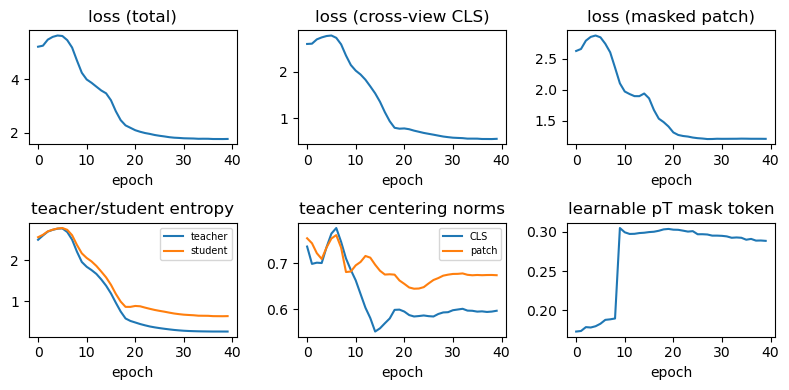

In [ ]:
normal_mask_train = (y_train[:,0] + y_train[:,1])==1
anomaly_mask_train = ~normal_mask_train

x_train_normal = x_train[normal_mask_train]
x_train_anomaly = x_train[anomaly_mask_train]

masker_ad = MaskTokens(d_model, name="particle_masker")
center_cls_ad = tf.Variable(tf.zeros([d_proj]), trainable=False)
center_patch_ad = tf.Variable(tf.zeros([d_proj]), trainable=False)

history_ibot_2class = train_ibot(x_train=x_train_normal,
                                 epochs=40,
                                 batch_size=256,
                                 #optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
                                 optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                                 ema_tau=0.996,
                                 student=student_ad,
                                 teacher=teacher_ad,
                                 proj_head_s=proj_head_s_ad,
                                 proj_head_t=proj_head_t_ad,
                                 mask_ratio_ibot=0.4,
                                 masker=masker_ad,
                                 center_cls=center_cls_ad,
                                 center_patch=center_patch_ad,
                                 center_beta=0.9,
                                 temp_t=0.04,
                                 temp_s=0.1)

plot_ibot_training(history_ibot_2class)

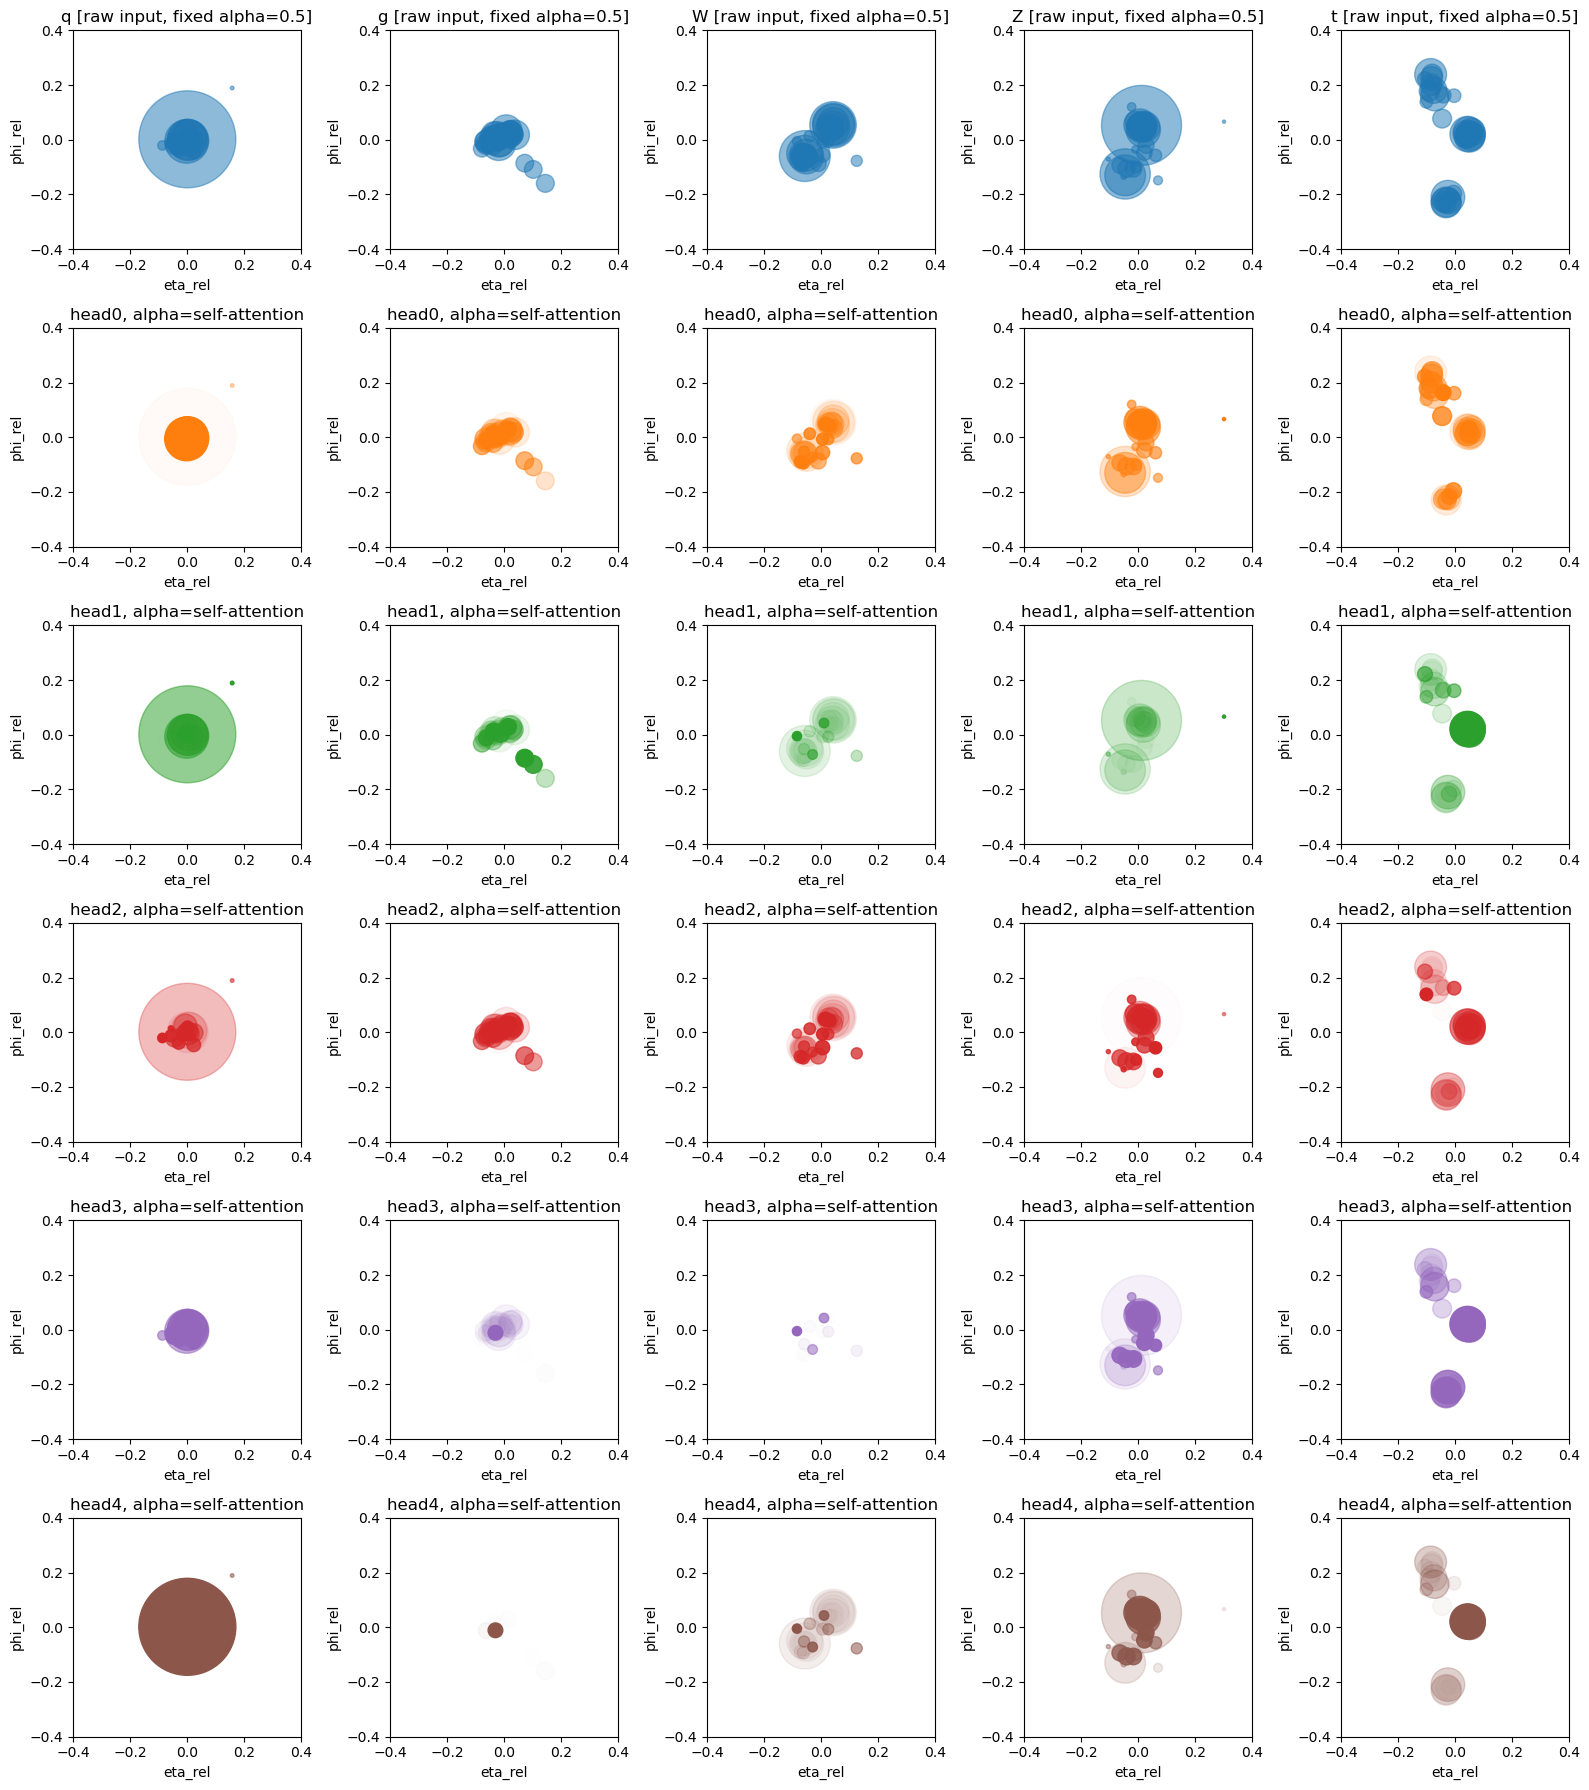

In [ ]:
plot_attention(transformer=student_ad, n_heads=n_heads, n_layers=n_layers)

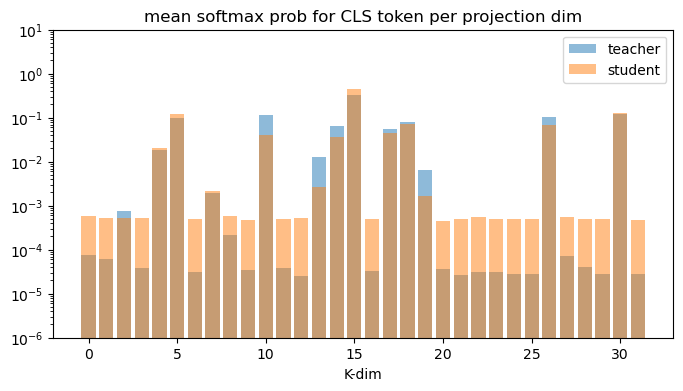

In [ ]:
plot_softmax_prob_cls(n_samples=5000,
                      student=student_ad, teacher=teacher_ad,
                      proj_head_s=proj_head_s_ad, proj_head_t=proj_head_t_ad,
                      center_cls=center_cls_ad, temp_t=0.04, temp_s=0.1)

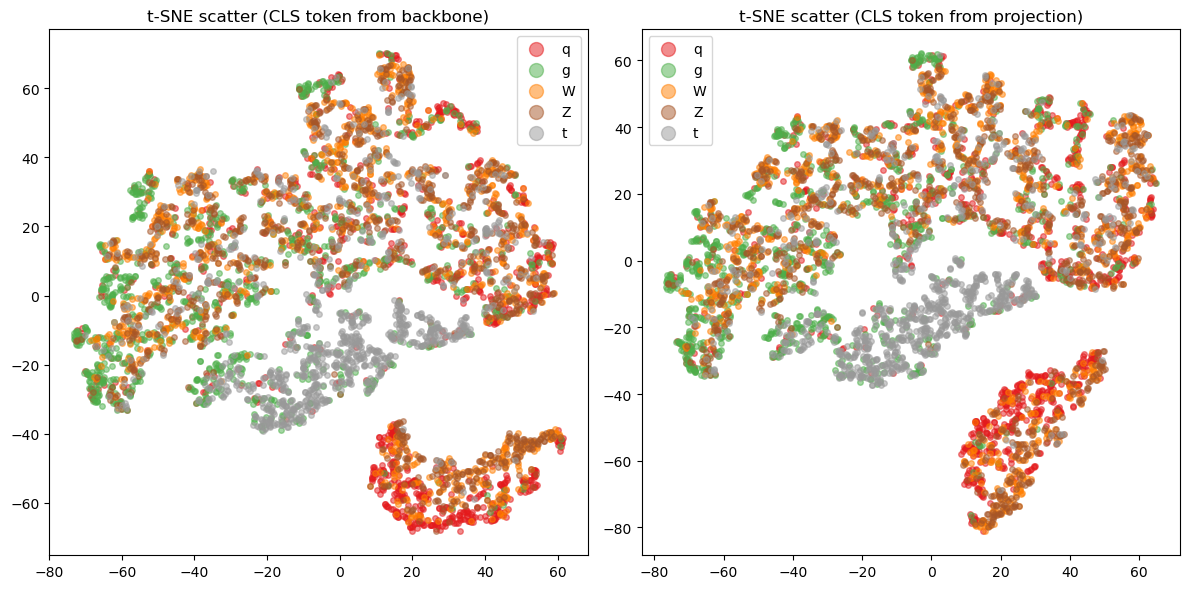

In [ ]:
plot_tSNE_cls(n_samples=5000, student=student_ad, proj_head_s=proj_head_s_ad)

In [43]:
z_train_normal = student_ad.predict(x_train_normal)[0]
knn_ad_bank = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(z_train_normal)
cosim_ad_bank = z_train_normal / np.linalg.norm(z_train_normal, axis=1, keepdims=True)
M = cosim_ad_bank.shape[0]

z_train_normal_t = teacher_ad.predict(x_train_normal)[0]
knn_ad_bank_t = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(z_train_normal_t)
cosim_ad_bank_t = z_train_normal_t / np.linalg.norm(z_train_normal_t, axis=1, keepdims=True)

def ad_score_knn(x, student_ad, knn_ad_bank):
    z = student_ad.predict(x)[0] 
    dist, _ = knn_ad_bank.kneighbors(z)
    return dist.mean(axis=1)

def ad_score_cosim(x, student_ad, cosim_ad_bank, sum_or_max, tau=0.04):
    z = student_ad.predict(x)[0]
    z = z / np.linalg.norm(z, axis=1, keepdims=True)
    sim = np.dot(z, cosim_ad_bank.T)
    if sum_or_max=="sum":
        return -np.mean(np.exp(sim / tau), axis=1) * 1e-10
    elif sum_or_max=="max":
        return 1-np.max(sim, axis=1) 

normal_mask_test = (y_test[:,0]==1) | (y_test[:,1]==1)
x_test_normal = x_test[normal_mask_test]
score_knn_normal = ad_score_knn(x_test_normal, student_ad, knn_ad_bank)
score_cosim_max_normal = ad_score_cosim(x_test_normal, student_ad, cosim_ad_bank, "max")

score_knn_normal_t = ad_score_knn(x_test_normal, teacher_ad, knn_ad_bank_t)
score_cosim_max_normal_t = ad_score_cosim(x_test_normal, teacher_ad, cosim_ad_bank_t, "max")

anomaly_classes = {2:'W', 3:'Z', 4:'t'}
scores_knn_anomaly = {}
scores_cosim_max_anomaly = {}

scores_knn_anomaly_t = {}
scores_cosim_max_anomaly_t = {}

for i,(col,name) in enumerate(anomaly_classes.items()):
    anomaly_mask_test = y_test[:,col]==1
    x_test_anomaly = x_test[anomaly_mask_test]
    scores_knn_anomaly[name] = ad_score_knn(x_test_anomaly, student_ad, knn_ad_bank)
    scores_cosim_max_anomaly[name] = ad_score_cosim(x_test_anomaly, student_ad, cosim_ad_bank, "max")
    # teacher
    scores_knn_anomaly_t[name] = ad_score_knn(x_test_anomaly, teacher_ad, knn_ad_bank_t)
    scores_cosim_max_anomaly_t[name] = ad_score_cosim(x_test_anomaly, teacher_ad, cosim_ad_bank_t, "max")

2472/2472 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2472/2472 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


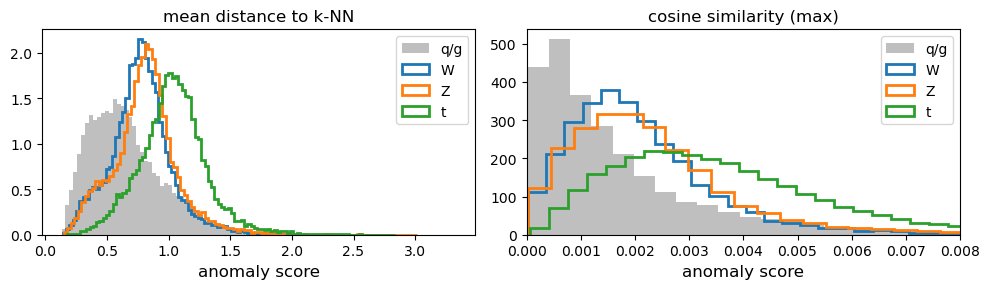

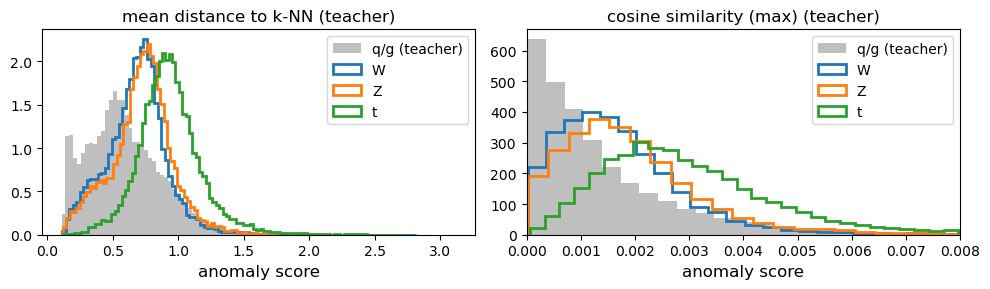

In [44]:
fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].hist(score_knn_normal, bins=100, density=True, color='grey', alpha=0.5, label='q/g')
for (name, score), i in zip(scores_knn_anomaly.items(), range(len(scores_knn_anomaly))):
    ax[0].hist(score, bins=100, density=True, histtype='step', linewidth=2, color=f"C{i}", label=f"{name}")
ax[0].set_xlabel("anomaly score", size=12)
ax[0].set_title("mean distance to k-NN", size=12)
ax[0].legend(fontsize=10)

ax[1].hist(score_cosim_max_normal, bins=100, density=True, color='grey', alpha=0.5, label='q/g')
for (name, score), i in zip(scores_cosim_max_anomaly.items(), range(len(scores_cosim_max_anomaly))):
    ax[1].hist(score, bins=100, density=True, histtype='step', linewidth=2, color=f"C{i}", label=f"{name}")
ax[1].set_xlabel("anomaly score", size=12)
ax[1].set_title("cosine similarity (max)", size=12)
ax[1].set_xlim(0,0.008)
ax[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2,figsize=(10,3))

ax[0].hist(score_knn_normal_t, bins=100, density=True, color='grey', alpha=0.5, label='q/g (teacher)')
for (name, score), i in zip(scores_knn_anomaly_t.items(), range(len(scores_knn_anomaly_t))):
    ax[0].hist(score, bins=100, density=True, histtype='step', linewidth=2, color=f"C{i}", label=f"{name}")
ax[0].set_xlabel("anomaly score", size=12)
ax[0].set_title("mean distance to k-NN (teacher)", size=12)
ax[0].legend(fontsize=10)

ax[1].hist(score_cosim_max_normal_t, bins=100, density=True, color='grey', alpha=0.5, label='q/g (teacher)')
for (name, score), i in zip(scores_cosim_max_anomaly_t.items(), range(len(scores_cosim_max_anomaly_t))):
    ax[1].hist(score, bins=100, density=True, histtype='step', linewidth=2, color=f"C{i}", label=f"{name}")
ax[1].set_xlabel("anomaly score", size=12)
ax[1].set_title("cosine similarity (max) (teacher)", size=12)
ax[1].set_xlim(0,0.008)
ax[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

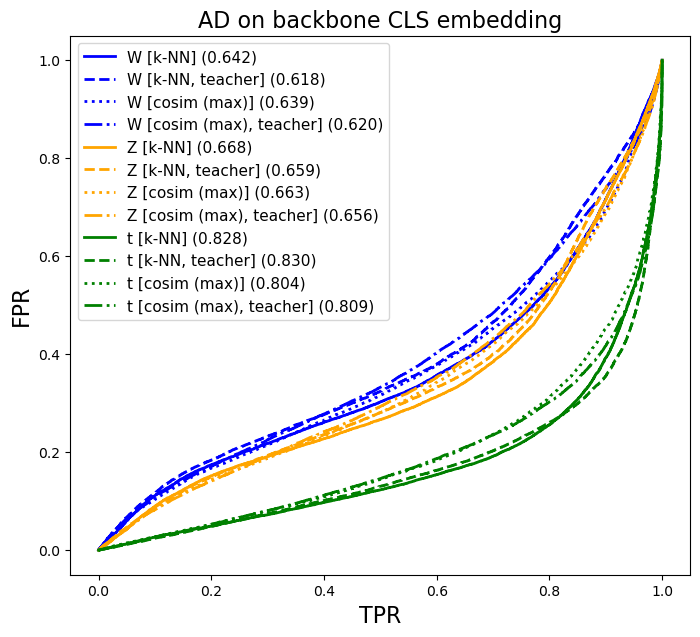

In [45]:
plt.figure(figsize=(8,7))
colors = ["blue", "orange", "green"]

for i,(col,name) in enumerate(anomaly_classes.items()):
    y_true = np.concatenate([np.zeros_like(score_knn_normal), np.ones_like(scores_knn_anomaly[name])])
    scores = np.concatenate([score_knn_normal, scores_knn_anomaly[name]])
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_ = auc(fpr, tpr)
    plt.plot(tpr, fpr, color=colors[i], label=f"{name} [k-NN] ({auc_:.3f})", linestyle="-", lw=2)

    y_true_t = np.concatenate([np.zeros_like(score_knn_normal_t), np.ones_like(scores_knn_anomaly_t[name])])
    scores_t = np.concatenate([score_knn_normal_t, scores_knn_anomaly_t[name]])
    fpr_t, tpr_t, _ = roc_curve(y_true_t, scores_t)
    auc_t = auc(fpr_t, tpr_t)
    plt.plot(tpr_t, fpr_t, color=colors[i], label=f"{name} [k-NN, teacher] ({auc_t:.3f})", linestyle="--", lw=2)

    y_true = np.concatenate([np.zeros_like(score_cosim_max_normal), np.ones_like(scores_cosim_max_anomaly[name])])
    scores = np.concatenate([score_cosim_max_normal, scores_cosim_max_anomaly[name]])
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_ = auc(fpr, tpr)
    plt.plot(tpr, fpr, color=colors[i], label=f"{name} [cosim (max)] ({auc_:.3f})", linestyle="dotted", lw=2)

    y_true_t = np.concatenate([np.zeros_like(score_cosim_max_normal_t), np.ones_like(scores_cosim_max_anomaly_t[name])])
    scores_t = np.concatenate([score_cosim_max_normal_t, scores_cosim_max_anomaly_t[name]])
    fpr_t, tpr_t, _ = roc_curve(y_true_t, scores_t)
    auc_t = auc(fpr_t, tpr_t)
    plt.plot(tpr_t, fpr_t, color=colors[i], label=f"{name} [cosim (max), teacher] ({auc_t:.3f})", linestyle="-.", lw=2)

plt.xlabel("TPR", size=16)
plt.ylabel("FPR", size=16)
#plt.yscale("log")
#plt.ylim(1e-4,1)
plt.title("AD on backbone CLS embedding", size=16)
plt.legend(fontsize=11)
plt.show()